# Word2vec
可參考 
* https://en.wikipedia.org/wiki/Word2vec
* http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* https://www.tensorflow.org/tutorials/word2vec

In [1]:
# windows only hack for graphviz path 
import os
for path in os.environ['PATH'].split(os.pathsep):
    if path.endswith("Library\\bin"):
        os.environ['PATH']+=os.pathsep+os.path.join(path, 'graphviz')

In [2]:
# 設定環境變數來控制 keras, theano
os.environ['KERAS_BACKEND']="tensorflow"
os.environ['THEANO_FLAGS']="floatX=float32, device=cuda"

In [3]:
import numpy as np

## 下載資料

In [4]:
import os
import urllib
from urllib.request import urlretrieve

# 大小是 26M
dataset ="text8.bz2"
origin_url = "https://github.com/tjwei/tf-play/raw/master/text8.bz2"

def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
    
if not os.path.isfile(dataset):
        print('Downloading data from %s' % origin_url)
        urlretrieve(origin_url, dataset, reporthook=reporthook)

In [5]:
import bz2
with bz2.open(dataset, "rt") as text8_file:
    words = text8_file.read().split()

print('Data size', len(words))
words[:20]

Data size 17005207


['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english']

### 先處理掉少用字

In [6]:
# 總共有多少種字？
len(set(words))

253854

我們只考慮最常用的 50000 字， 其他字用 UNK 取代

In [7]:
import collections
# 先統計字數
counter = collections.Counter(words)
# 可以看一下 counter 是的內容

In [8]:
# 最常見的 20 個字
counter.most_common(20)

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644),
 ('is', 183153),
 ('as', 131815),
 ('eight', 125285),
 ('for', 118445),
 ('s', 116710),
 ('five', 115789),
 ('three', 114775),
 ('was', 112807),
 ('by', 111831),
 ('that', 109510)]

In [9]:
vocabulary_size = 50000
wordfreq = counter.most_common(vocabulary_size-1)


# 建立 編號: 字 的對照表
num2word = ['UNK'] + [w for (w, _) in wordfreq]
freq = np.array([0]+[n for (_, n) in wordfreq], dtype="float64")
freq[0] = len(words) - freq.sum()
freq = (np.sqrt(freq/0.001)+1)*9.001/freq
# 建立一個 字: 編號 的對照表
word2num = {w: i for i, w in enumerate(num2word)}

# 把 words 轉成對定的編號
data = np.array([word2num.get(word, 0) for word in words])
# 不需要 words 了
del words
del wordfreq
freq[:10]

array([ 0.44006905,  0.27629013,  0.36943112,  0.44099868,  0.44359636,
        0.46657827,  0.49864404,  0.50607328,  0.55298709,  0.56882022])

看一下目前的狀況

In [10]:
print(data[:20])
print(" - ".join(num2word[n] for n in data[:20]))

[ 5241  3083    12     6   195     2  3135    46    59   156   128   742
   477 10595   134     1 27692     2     1   103]
anarchism - originated - as - a - term - of - abuse - first - used - against - early - working - class - radicals - including - the - diggers - of - the - english


生成 skip-gram 模型的 batch

keywords skipgram, cbow, n-gram

In [11]:
import keras.backend as K

Using TensorFlow backend.


In [12]:
from keras.layers import Embedding, Dense, Flatten, Input
from keras.models import Sequential, Model
import keras.backend as K
import tensorflow as tf

# vector 的維度
embedding_size = 128

# 這其實只是線性映射，只不過輸入不是 one hot 而是 integer， 所以等同查表
word2vec = Sequential()
word2vec.add(Embedding(vocabulary_size, embedding_size, input_length=1))
word2vec.add(Flatten())
train_input = word2vec.inputs[0]
embeddings = word2vec.layers[0].embeddings 

# 對應到的 context
train_labels = Input(shape=(1,), dtype="int32")

# 這裡利用 tensorflow 的 nce_loss
nce_W = K.variable(K.random_normal((vocabulary_size, embedding_size),stddev=(embedding_size)**-0.5))
loss = K.mean(tf.nn.nce_loss(
                     weights=nce_W,
                     biases=K.zeros((vocabulary_size,)),
                     labels=train_labels,
                     inputs=word2vec.output,
                     num_sampled=64, # Number of negative examples to sample.
                     num_classes=vocabulary_size))

# 利用 tensorflow 的 optimizer
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

# 之後要拿來檢驗的例子
valid_examples = np.array([word2num[x] for x in ["five", "many", "american", "time", "see", "war", "history", "he"]])
valid_size = len(valid_examples)
valid_dataset = K.constant(valid_examples[:, None], "int32")
valid_embeddings = word2vec(valid_dataset)

# 正規化 embeddings, 來找 nearest neighbor 
normalized_embeddings = K.l2_normalize(embeddings, 1)
similarity = K.dot(valid_embeddings, K.transpose(normalized_embeddings))

# Add variable initializer.
init = tf.global_variables_initializer()

In [13]:
def skipgram_batch(data, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window    
    context_length = skip_window*2+1
    X = np.ndarray(shape=batch_size, dtype=np.int32)
    Y = np.ndarray(shape=batch_size, dtype=np.int32)
    idx = 0
    while True:
        for i in range(0, batch_size, num_skips):
            X[i:i+num_skips] = data[idx+skip_window]            
            context = data[idx:idx+context_length][np.arange(context_length) != skip_window]        
            # subsampling 機率
            #p = np.ones(2*skip_window)/2/skip_window
            Y[i:i+num_skips] = np.random.choice(context, size=num_skips, replace=False)
            idx = (idx+1)%(len(data)-context_length)
        yield X[:, None], Y
# 測試看看
X,Y = next(skipgram_batch(data, 20, 4, 3))
for x,y in zip(X, Y):
    print("{} -> {}".format(num2word[x[0]], num2word[y]) )

a -> term
a -> originated
a -> as
a -> of
term -> of
term -> a
term -> as
term -> originated
of -> abuse
of -> used
of -> a
of -> first
abuse -> term
abuse -> used
abuse -> against
abuse -> of
first -> early
first -> abuse
first -> against
first -> used


In [14]:
import time
t0 = time.time()
batch_gen = skipgram_batch(data, batch_size=128, num_skips=4, skip_window=3)
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    for step in range(0,200001):
        X,Y = next(batch_gen)
        feed_dict = {train_input: X, train_labels: Y[:, None]}
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        if step >0 and step %10000 == 0:
            print(step, "average loss", average_loss/2000, time.time()-t0)
            average_loss = 0
        if step % 50000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = num2word[valid_examples[i]]
                nearest = (-sim[i, :]).argsort()[1:8 + 1]
                print(valid_word, [num2word[x] for x in nearest])
    final_embeddings = normalized_embeddings.eval()

two ['impedes', 'closure', 'rovere', 'denarius', 'volante', 'nielsen', 'quitting', 'directly']
many ['mediating', 'applicants', 'accountants', 'langle', 'senna', 'unenforceable', 'boots', 'ewald']
american ['factions', 'network', 'cuyahoga', 'yugoslavia', 'eu', 'approaches', 'straightforward', 'fl']
time ['frac', 'mentioning', 'imitators', 'caution', 'peruvian', 'rolle', 'vistula', 'wir']
see ['concentrations', 'classmates', 'turquoise', 'deletions', 'cytoplasm', 'dench', 'suv', 'guidance']
war ['gambler', 'aar', 'yitzhak', 'classroom', 'amigas', 'niro', 'oceanography', 'ferrol']
history ['parthian', 'corey', 'blink', 'recordable', 'st', 'totals', 'tora', 'scrambling']
he ['enfant', 'formic', 'perkins', 'chinaman', 'stephens', 'muslim', 'quit', 'appellation']
10000 average loss 242.930388102 21.212551832199097
20000 average loss 57.7697343271 40.087703466415405
30000 average loss 37.3264281052 61.18580627441406
40000 average loss 31.3296706051 81.25465941429138
50000 average loss 28.88

In [15]:
def find_sim(v, num=10):
    if isinstance(v, str):
        v = w2v(v)
    return [num2word[x] for x in  (final_embeddings @ v).argsort()[-num-1:-1][::-1]]
def w2v(w):
    return final_embeddings[word2num.get(w, 0)] 
find_sim('dog')

['holly',
 'printer',
 'teletype',
 'agar',
 'grey',
 'horseman',
 'tack',
 'nepeta',
 'broglie',
 'whorf']

In [16]:
find_sim('car')

['suite',
 'phoneme',
 'ensemble',
 'turret',
 'carbonyl',
 'fighter',
 'bbs',
 'dwarfs',
 'dew',
 'facility']

In [20]:
find_sim('king')

['constantine',
 'pope',
 'henry',
 'queen',
 'prince',
 'duke',
 'emperor',
 'son',
 'lord',
 'charles']

In [22]:
find_sim(w2v('king')-w2v('men')+w2v("women"))

['queen',
 'constantine',
 'prince',
 'emperor',
 'duke',
 'philip',
 'elizabeth',
 'henry',
 'caesar',
 'alexander']

In [18]:
# 用 t-sne 降低維度
from sklearn.manifold import TSNE
samples = 500
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(final_embeddings[:samples])
labels = num2word[:samples]

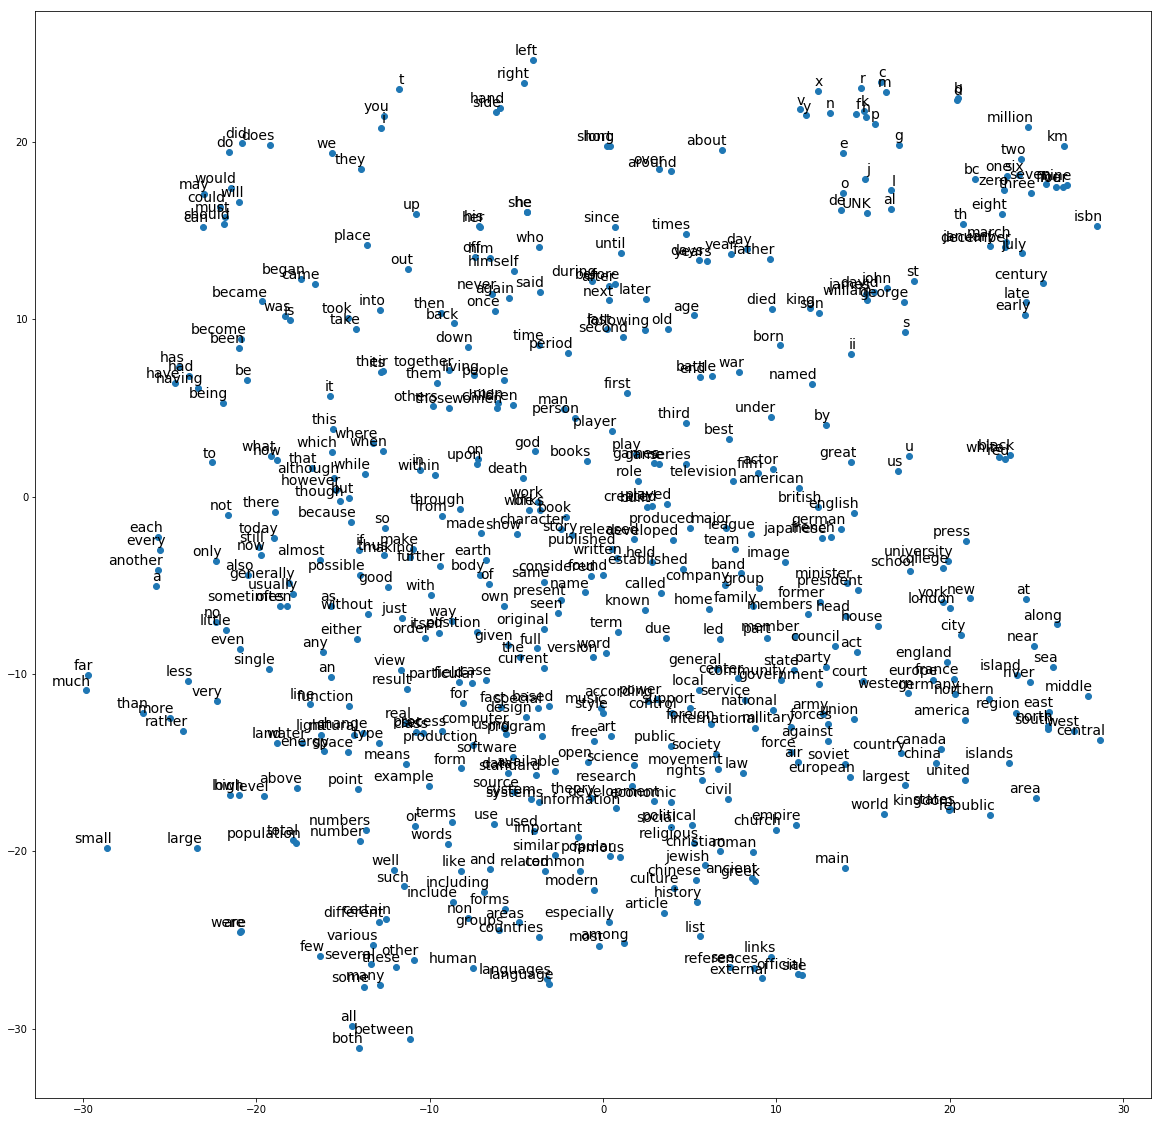

In [19]:
# 畫出來
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1])
for i, label in enumerate(labels):
    x, y = low_dim_embs[i]
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 fontsize=14,
                 ha='right',
                 va='bottom')